In [47]:
import os 
import sys
while os.path.split(os.getcwd())[1] != 'RecSysChallenge2023-Team':
    os.chdir('..')
sys.path.insert(1, os.getcwd())

import numpy as np

In [48]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

import Daniele.Utils.MyDataManager as dm 
import Daniele.Utils.MatrixManipulation as mm

URMv = dm.getURMviews()
URMo = dm.getURMopen()
ICMt=dm.getICMt()
ICMl=dm.getICMl()


URMv_train, URMv_test = split_train_in_two_percentage_global_sample(URMv, train_percentage = 0.80)

urm_def = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)

urm_bin = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo, normalize=False, add_aug=True)
urm_bin.data = np.ones(len(urm_bin.data))

  2%|▏         | 546/27968 [00:00<00:05, 5451.60it/s]

100%|██████████| 663370/663370 [00:00<00:00, 723044.99it/s]


### SSLIIM

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

sslim_recommender = SLIM_BPR_Cython(URM_train=urm_def)
sslim_recommender.fit(topK= 305, epochs=25,symmetric=True, sgd_mode = 'adam', lambda_i = 0.0008132913041259862, lambda_j=0.004889521240194745, learning_rate = 0.005381553515814384)

SLIM_BPR_Recommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.


/bin/sh: free: command not found


Processed 70382 (100.0%) in 2.24 sec. BPR loss is 8.61E-01. Sample per second: 31425
SLIM_BPR_Recommender: Epoch 1 of 25. Elapsed time 1.28 sec
Processed 70382 (100.0%) in 0.61 sec. BPR loss is 3.07E+00. Sample per second: 115762
SLIM_BPR_Recommender: Epoch 2 of 25. Elapsed time 1.65 sec
Processed 70382 (100.0%) in 0.90 sec. BPR loss is 5.37E+00. Sample per second: 77905
SLIM_BPR_Recommender: Epoch 3 of 25. Elapsed time 1.94 sec
Processed 70382 (100.0%) in 1.20 sec. BPR loss is 7.42E+00. Sample per second: 58834
SLIM_BPR_Recommender: Epoch 4 of 25. Elapsed time 2.24 sec
Processed 70382 (100.0%) in 0.49 sec. BPR loss is 9.28E+00. Sample per second: 143096
SLIM_BPR_Recommender: Epoch 5 of 25. Elapsed time 2.53 sec
Processed 70382 (100.0%) in 0.78 sec. BPR loss is 1.17E+01. Sample per second: 90510
SLIM_BPR_Recommender: Epoch 6 of 25. Elapsed time 2.82 sec
Processed 70382 (100.0%) in 1.07 sec. BPR loss is 1.32E+01. Sample per second: 65718
SLIM_BPR_Recommender: Epoch 7 of 25. Elapsed time

### KNN_CFCBF 

In [51]:
from Daniele.Recommenders.KNN_CFCBF.ItemKNN_CFCBF_Hybrid_Recommender import KNN_CFCBF_custom

KNN_recommender = KNN_CFCBF_custom(URMv_train,URMo,ICM_train=mm.augmentedICM(ICMt,ICMl))
KNN_recommender.fit(topK= 744, shrink= 457, similarity= 'cosine', normalize= True, feature_weighting='TF-IDF')

KNN_CFCBF_custom: URM Detected 3461 (12.4%) items with no interactions.
Beta-> 1.0 	ICM_weight-> 1.0
Similarity column 27968 (100.0%), 2302.51 column/sec. Elapsed time 12.15 sec


### RP3Beta 


In [52]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

rp3beta_recommender = RP3betaRecommender(urm_bin)
rp3beta_recommender.fit(topK= 89, alpha= 0.6361002951626124, beta= 0.27432996564004203, normalize_similarity= True)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 2672.58 column/sec. Elapsed time 10.46 sec


### RP3Beta - KNN_CFCBF

In [53]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
alpha_knn_rp3 = 0.7

knn_rp3_recommender = ItemKNNCustomSimilarityRecommender(urm_def)
knn_rp3_recommender.fit((1 - alpha_knn_rp3) * KNN_recommender.W_sparse + alpha_knn_rp3* rp3beta_recommender.W_sparse)

ItemKNNCustomSimilarityRecommender: URM Detected 2 ( 0.0%) users with no interactions.


### TopPop

In [54]:
from Recommenders.NonPersonalizedRecommender import TopPop

most_viewed = TopPop(urm_bin)
most_viewed.fit()

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.


### REFERENCE RP3Beta 0.052

In [55]:
best_reference = RP3betaRecommender(urm_bin)
#{'topK': 106, 'alpha': 0.6155817289031643, 'beta': 0.33427474623540737, 'normalize_similarity': True} -> MAP 0.0276355
best_reference.fit(topK= 106, alpha= 0.6155817289031643, beta= 0.33427474623540737, normalize_similarity= True)


RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 2495.76 column/sec. Elapsed time 11.21 sec


### Hybrid

In [56]:
from Daniele.Recommenders.Hybrid_KNN_RP3Beta_SSLIM.hybrid import SSLIMRP3BetaKNNRecommender

hybrid = SSLIMRP3BetaKNNRecommender(URMv_train,URMo,ICMt,ICMl)
# hybrid.fit()
hybrid.rp3beta_recommender = rp3beta_recommender
hybrid.KNN_recommender = KNN_recommender
hybrid.sslim_recommender = sslim_recommender
hybrid.knn_rp3_recommender = knn_rp3_recommender
hybrid.most_viewed = most_viewed

100%|██████████| 663370/663370 [00:00<00:00, 748047.31it/s]


RP3BetaKNNRecommender: URM Detected 3461 (12.4%) items with no interactions.


### Users group

In [57]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URMv).indptr)
profile_length, profile_length.shape

block_size = int(len(profile_length)*0.05)
sorted_users = np.argsort(profile_length)

for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 6.98, median 7.0, min 2, max 9
Group 1, #users in group 2081, average p.len 9.43, median 9.0, min 9, max 10
Group 2, #users in group 2081, average p.len 10.69, median 11.0, min 10, max 11
Group 3, #users in group 2081, average p.len 11.83, median 12.0, min 11, max 12
Group 4, #users in group 2081, average p.len 12.88, median 13.0, min 12, max 13
Group 5, #users in group 2081, average p.len 13.92, median 14.0, min 13, max 14
Group 6, #users in group 2081, average p.len 14.92, median 15.0, min 14, max 15
Group 7, #users in group 2081, average p.len 16.00, median 16.0, min 15, max 17
Group 8, #users in group 2081, average p.len 17.22, median 17.0, min 17, max 18
Group 9, #users in group 2081, average p.len 18.42, median 18.0, min 18, max 19
Group 10, #users in group 2081, average p.len 19.75, median 20.0, min 19, max 21
Group 11, #users in group 2081, average p.len 21.44, median 21.0, min 21, max 22
Group 12, #users in group 2081, average p.len

In [58]:
MAP_recommender_per_group = {}
recommender_object_dict = {}

recommender_class = {"best_reference" :best_reference,
                     "hybrid" : hybrid,
                     "rp3beta_recommender" : rp3beta_recommender,
                     "KNN_recommender" : KNN_recommender,
                     "sslim_recommender" : sslim_recommender,
                     "knn_rp3_recommender" : knn_rp3_recommender,
                     #"most_viewed" : most_viewed,
                     }


for label, recommender_obj in recommender_class.items():
    recommender_object_dict[label] = recommender_obj

Deallocating Cython objects
Deallocating Cython objects


In [59]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URMv_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 2081, average p.len 6.98, median 7.0, min 2, max 9
EvaluatorHoldout: Ignoring 1527 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1606 (100.0%) in 2.98 sec. Users per second: 539
EvaluatorHoldout: Processed 1606 (100.0%) in 6.06 sec. Users per second: 265
EvaluatorHoldout: Processed 1606 (100.0%) in 2.86 sec. Users per second: 561
EvaluatorHoldout: Processed 1606 (100.0%) in 2.57 sec. Users per second: 625
EvaluatorHoldout: Processed 1606 (100.0%) in 2.96 sec. Users per second: 542
EvaluatorHoldout: Processed 1606 (100.0%) in 3.28 sec. Users per second: 490
Group 1, #users in group 2081, average p.len 9.43, median 9.0, min 9, max 10
EvaluatorHoldout: Ignoring 1527 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1821 (100.0%) in 2.92 sec. Users per second: 624
EvaluatorHoldout: Processed 1821 (100.0%) in 5.41 sec. Use

/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 2057 (100.0%) in 3.11 sec. Users per second: 662
EvaluatorHoldout: Processed 2057 (100.0%) in 4.40 sec. Users per second: 467
EvaluatorHoldout: Processed 2057 (100.0%) in 3.06 sec. Users per second: 672
EvaluatorHoldout: Processed 2057 (100.0%) in 3.45 sec. Users per second: 596
EvaluatorHoldout: Processed 2057 (100.0%) in 3.31 sec. Users per second: 622
EvaluatorHoldout: Processed 2057 (100.0%) in 4.17 sec. Users per second: 494
Group 11, #users in group 2081, average p.len 21.44, median 21.0, min 21, max 22
EvaluatorHoldout: Ignoring 1527 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2072 (100.0%) in 3.10 sec. Users per second: 669
EvaluatorHoldout: Processed 2072 (100.0%) in 4.23 sec. Users per second: 489
EvaluatorHoldout: Processed 2072 (100.0%) in 3.05 sec. Users per second: 679
EvaluatorHoldout: Processed 2072 (100.0%) in 3.52 sec. Users per second: 589
EvaluatorHoldout: Proces

/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 2081 (100.0%) in 3.37 sec. Users per second: 617
EvaluatorHoldout: Processed 2081 (100.0%) in 4.31 sec. Users per second: 483
EvaluatorHoldout: Processed 2081 (100.0%) in 3.28 sec. Users per second: 635
EvaluatorHoldout: Processed 2081 (100.0%) in 4.24 sec. Users per second: 490
EvaluatorHoldout: Processed 2081 (100.0%) in 3.84 sec. Users per second: 542
EvaluatorHoldout: Processed 2081 (100.0%) in 5.18 sec. Users per second: 402
Group 19, #users in group 2081, average p.len 87.91, median 78.0, min 62, max 281
EvaluatorHoldout: Ignoring 1527 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 2081 (100.0%) in 3.47 sec. Users per second: 600
EvaluatorHoldout: Processed 2081 (100.0%) in 4.46 sec. Users per second: 466
EvaluatorHoldout: Processed 2081 (100.0%) in 3.46 sec. Users per second: 601
EvaluatorHoldout: Processed 2081 (100.0%) in 4.72 sec. Users per second: 441
EvaluatorHoldout: Proce

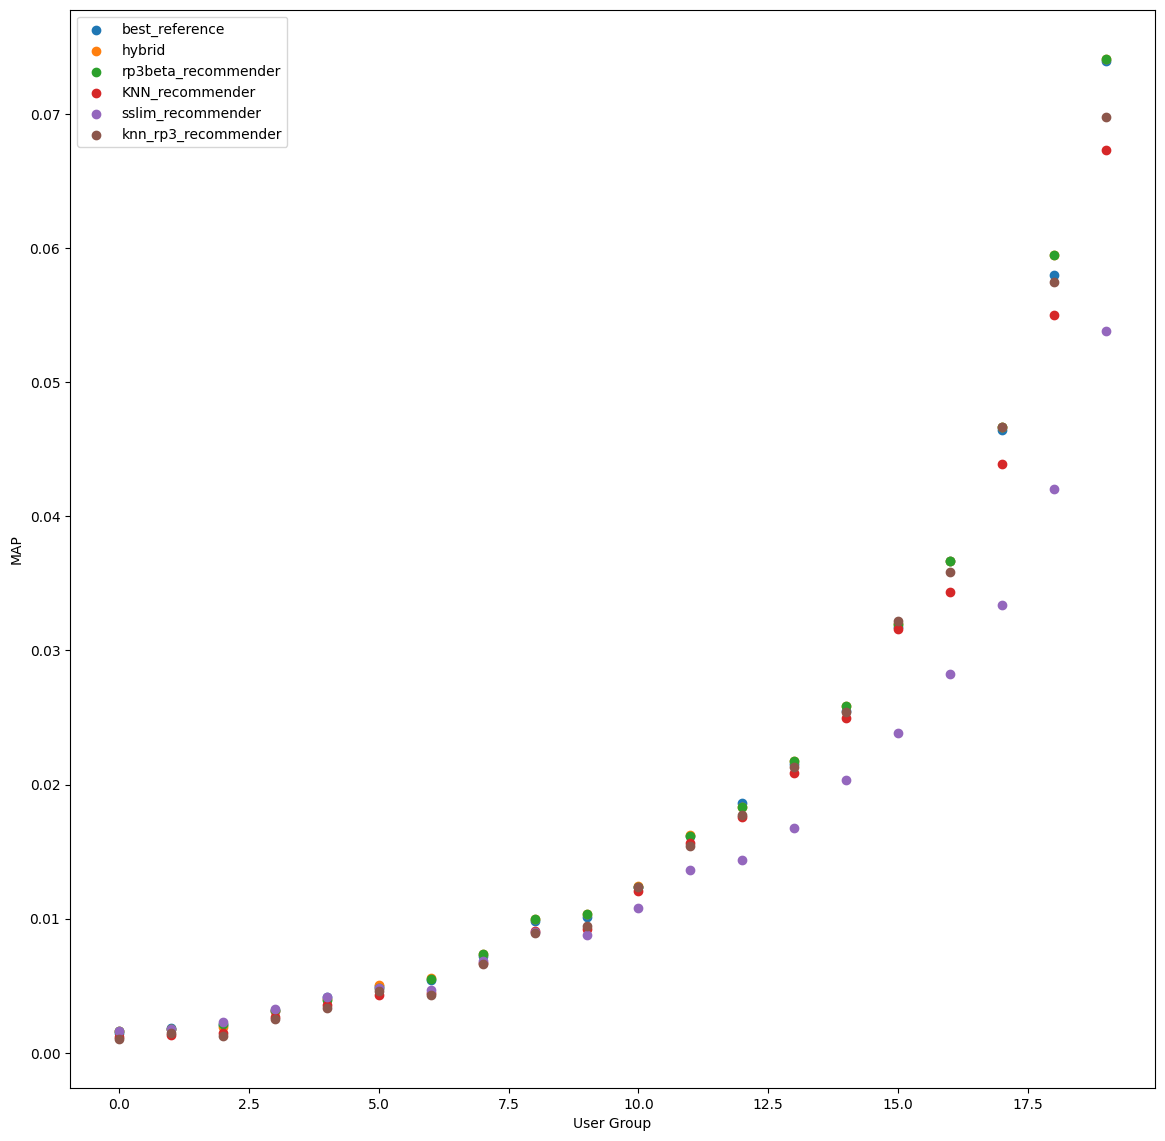

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(14, 14))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label,)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [31]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender(hybrid)
ris

EvaluatorHoldout: Ignoring 1563 ( 3.8%) Users that have less than 1 test interactions


/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 40066 (100.0%) in 1.38 min. Users per second: 483


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.055748,0.096214,0.090494,0.026343,0.042765,0.163402,NaN,0.068993,0.352618,0.205598,...,0.962454,0.339379,0.962454,0.1541,10.238117,0.994647,0.399329,0.77646,3.272638,0.419678


In [32]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender(best_reference)
ris

EvaluatorHoldout: Ignoring 1563 ( 3.8%) Users that have less than 1 test interactions


/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),


EvaluatorHoldout: Processed 40066 (100.0%) in 30.17 sec. Users per second: 1328


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.041035,0.06943,0.065082,0.020278,0.033597,0.134686,0.060508,0.050334,0.272301,0.163688,...,0.962454,0.262077,0.962454,0.047719,9.457064,0.995171,0.109127,0.703185,3.490068,0.276846


In [28]:
from tqdm import tqdm

f = open("submission.csv", "w+")
f.write("user_id,item_list\n")
for t in tqdm(dm.getUserIDtest_df().user_id):
    recommended_items = recommender.recommend(t, cutoff=10, remove_seen_flag=True)
    well_formatted = " ".join([str(x) for x in recommended_items])
    f.write(f"{t}, {well_formatted}\n")

100%|██████████| 41116/41116 [00:31<00:00, 1303.91it/s]
